In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [89]:
# Hyperparameters
batch_size = 128

# Transformations for adding noise
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset
train_data = datasets.CIFAR10(root='../_DATASETS', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = datasets.CIFAR10(root='../_DATASETS', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [108]:
print(len(train_data))

50000


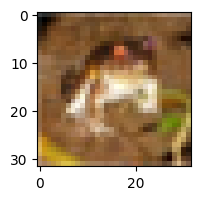

In [110]:
x, label = train_data[0]
plt.figure(figsize=(2,2))
plt.imshow(x.movedim(0,-1))

In [7]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = DenoisingAutoencoder()
criterion = nn.MSELoss()

In [71]:
# Training

noise_factor = 0.5
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in range(epochs):
    train_loss = 0.0
    # i = 0
    for data, _ in train_loader:
        noisy_data = data + noise_factor * torch.randn_like(data)  # Add noise to input
        noisy_data = torch.clamp(noisy_data, 0., 1.)  # Clamp values between 0 and 1
        
        # Forward pass
        outputs = model(noisy_data)
        loss = criterion(outputs, data)  # Compare to original clean image
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        
        # if i % 8 == 0:
            # print(f"{i + 1}: {loss}")
            
        # i += 1
    
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.10f}")

print("=========== Done ===========")

Epoch 1, Loss: 0.0110516901
=========== Done ===========


In [64]:
# torch.save({'model_state': model.state_dict()},'checkpoints/005.chk')

In [ ]:
# checkpoint = torch.load('checkpoints/005.chk')
# model.load_state_dict(checkpoint['model_state'])

Text(0.5, 1.0, 'Denoised')

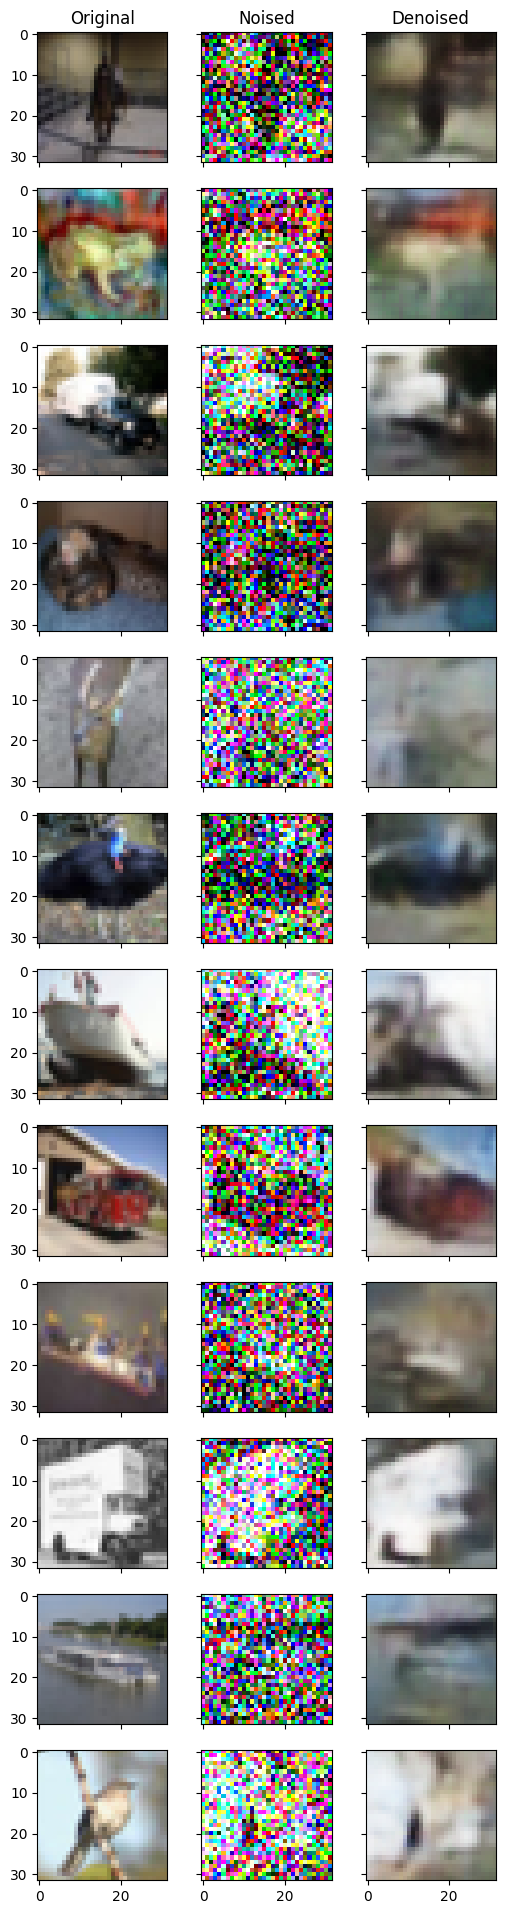

In [112]:
num_display_img = 12

test_loader = DataLoader(test_data, batch_size=num_display_img, shuffle=True)
images, _ = next(iter(test_loader))
# print(images.shape) # (12, 3, W, H)

model.eval()
with torch.no_grad():
    noised_images = images + noise_factor * torch.randn_like(images)
    noised_images = torch.clamp(noised_images, 0.0, 1.0)
    denoised_images = model(noised_images).detach()

_, axs = plt.subplots(num_display_img, 3,
                    figsize=(6, 2 * num_display_img),
                    sharex=True, sharey=True)

for i in range(num_display_img):
    image = images[i]
    noised_image = noised_images[i]
    denoised_image = denoised_images[i]

    axs[i, 0].imshow(image.movedim(0,-1))
    axs[i, 1].imshow(noised_image.movedim(0,-1))
    axs[i, 2].imshow(denoised_image.movedim(0,-1))

axs[0, 0].set_title("Original")
axs[0, 1].set_title("Noised")
axs[0, 2].set_title("Denoised")